# LNP Internalization

- Imaging DATE: 2024-09-17

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bioio import BioImage
from scipy import ndimage as ndi
from skimage import io, filters, exposure, segmentation, morphology, measure, feature
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'stixsans',
    'font.size': 18,

    'lines.linewidth': 2,

    'axes.linewidth': 2,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',

    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,

    'figure.dpi': 80,
    'savefig.dpi': 80,

    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14,

    'animation.html': 'html5',
})

In [3]:
DATE = '2024-09-17_erosion'
IMG_DIR = f'img_data/{DATE}'
IMG_FILENAMES = np.array([
    'exp_1_LNP_np.czi',
    'exp_2_cellonly_np.czi',
    'exp_3_LNP_VTN.czi',
    'exp_4_cellonly_VTN.czi',
    'exp_5_LNP_A2M.czi',
    'exp_6_cellonly_A2M.czi',
    'exp_7_LNP_CR.czi',
    'exp_8_cellonly_CR.czi',
    'exp_9_cellonly_np.czi',
    'exp_10_LNP_np.czi',
    'exp_11_LNP_VTN.czi',
    'exp_12_LNP_A2M.czi',
    'exp_13_LNP_CR.czi',
    'exp_14_cellonly_np.czi',
    'exp_15_LNP_np.czi',
    'exp_16_LNP_VTN.czi',
    'exp_17_LNP_A2M.czi',
    'exp_18_LNP_CR.czi',
    'exp_19_cellonlynostain_np.czi',
    'exp_20_LNP_APOE.czi',
    'exp_21_cellonly_APOE.czi',
    'exp_22_LNP_APOE.czi',
])
LNP_CHANNEL_IDX = 1
MEMBRANE_CHANNEL_IDX = 3
NUCLEUS_CHANNEL_IDX = 5

## Tuning thresholding methods

In [4]:
def get_scene_img(img, scene_idx):
    img.set_scene(scene_idx)
    lazy_t0 = img.get_image_dask_data("CYX")  # returns out-of-memory 4D dask array
    t0 = lazy_t0.compute()  # returns in-memory 4D numpy array
    return t0

In [5]:
def get_membrane_mask(img):
    # # for general images...
    # # segmentation by histogram-based thresholding
    # threshold = filters.threshold_li(img)
    # mask = (img > threshold)
    
    # # post-segmentation image processing
    # mask = morphology.remove_small_objects(mask, 3000)
    # mask = morphology.remove_small_holes(mask, 300)
    # mask = ndi.binary_fill_holes(mask)

    # for apoe images
    processed_img = exposure.adjust_log(img, 10)
    mask = processed_img > processed_img.max()*0.25  # note the thresholding that removes the noise
    # post-segmentation image processing
    mask = morphology.remove_small_objects(mask, 3000)
    mask = morphology.remove_small_holes(mask, 300)
    mask = ndi.binary_fill_holes(mask)
    return mask

def get_inner_membrane_mask(mask, n_erosion=10):
    inner_mask = mask.copy()
    for k in range(n_erosion):
        inner_mask = morphology.erosion(inner_mask)
    return inner_mask

def get_inner_outer_membrane_masks(mask, n_erosion=10):
    inner_mask = get_inner_membrane_mask(mask, n_erosion=n_erosion)
    outer_mask = np.bitwise_xor(inner_mask, membrane_mask)
    return inner_mask, outer_mask

def get_nucleus_mask(img):
    # adjust the histogram for image pre-thresholding
    processed_img = exposure.equalize_hist(img)
    
    # segmentation of img by local thresholding on processed_img
    threshold = filters.threshold_local(
        processed_img,
        block_size=35,  # 35
        offset=-3,  # -15 is good for exp 3, -3 is good for exp 1
    )
    mask = (img > threshold)
    
    # post-segmentation image processing
    mask = ndi.binary_fill_holes(mask)
    mask = morphology.remove_small_holes(mask)
    mask = morphology.remove_small_objects(mask, 500)
    for k in range(2):
        mask = morphology.erosion(mask)
    mask = morphology.remove_small_objects(mask, 2000)
    return mask

In [6]:
def remove_uncolocalized_objects(mask1, mask2, verbose=False):
    """
    mask1 contains objects of interest to be removed according to colocalization with mask 2
    Only removes objects that are completely not colocalized. Not based on percentage of colocalization.
    """
    mask1 = mask1.copy()  # avoid data leakage across scope
    mask2 = mask2.copy()  # avoid data leakage across scope
    labeled_mask1 = measure.label(mask1)
    for i in range(1, labeled_mask1.max() + 1):  # zero is background, shift to start from 1
        individual_labeled_mask1 = (labeled_mask1 == i)  # mask of one membrane
        colocalized_mask1 = np.logical_and(individual_labeled_mask1, mask2)  # all zeros if not colocalized
        colocalization_ratio = colocalized_mask1.sum() / individual_labeled_mask1.sum()  # how much is colocalized?
        is_colocalized = bool(colocalization_ratio)
        if not is_colocalized:
            mask1[labeled_mask1 == i] = 0  # remove uncolocalized membranes
            if verbose:
                print(f'Removed {i}th object')
    return mask1

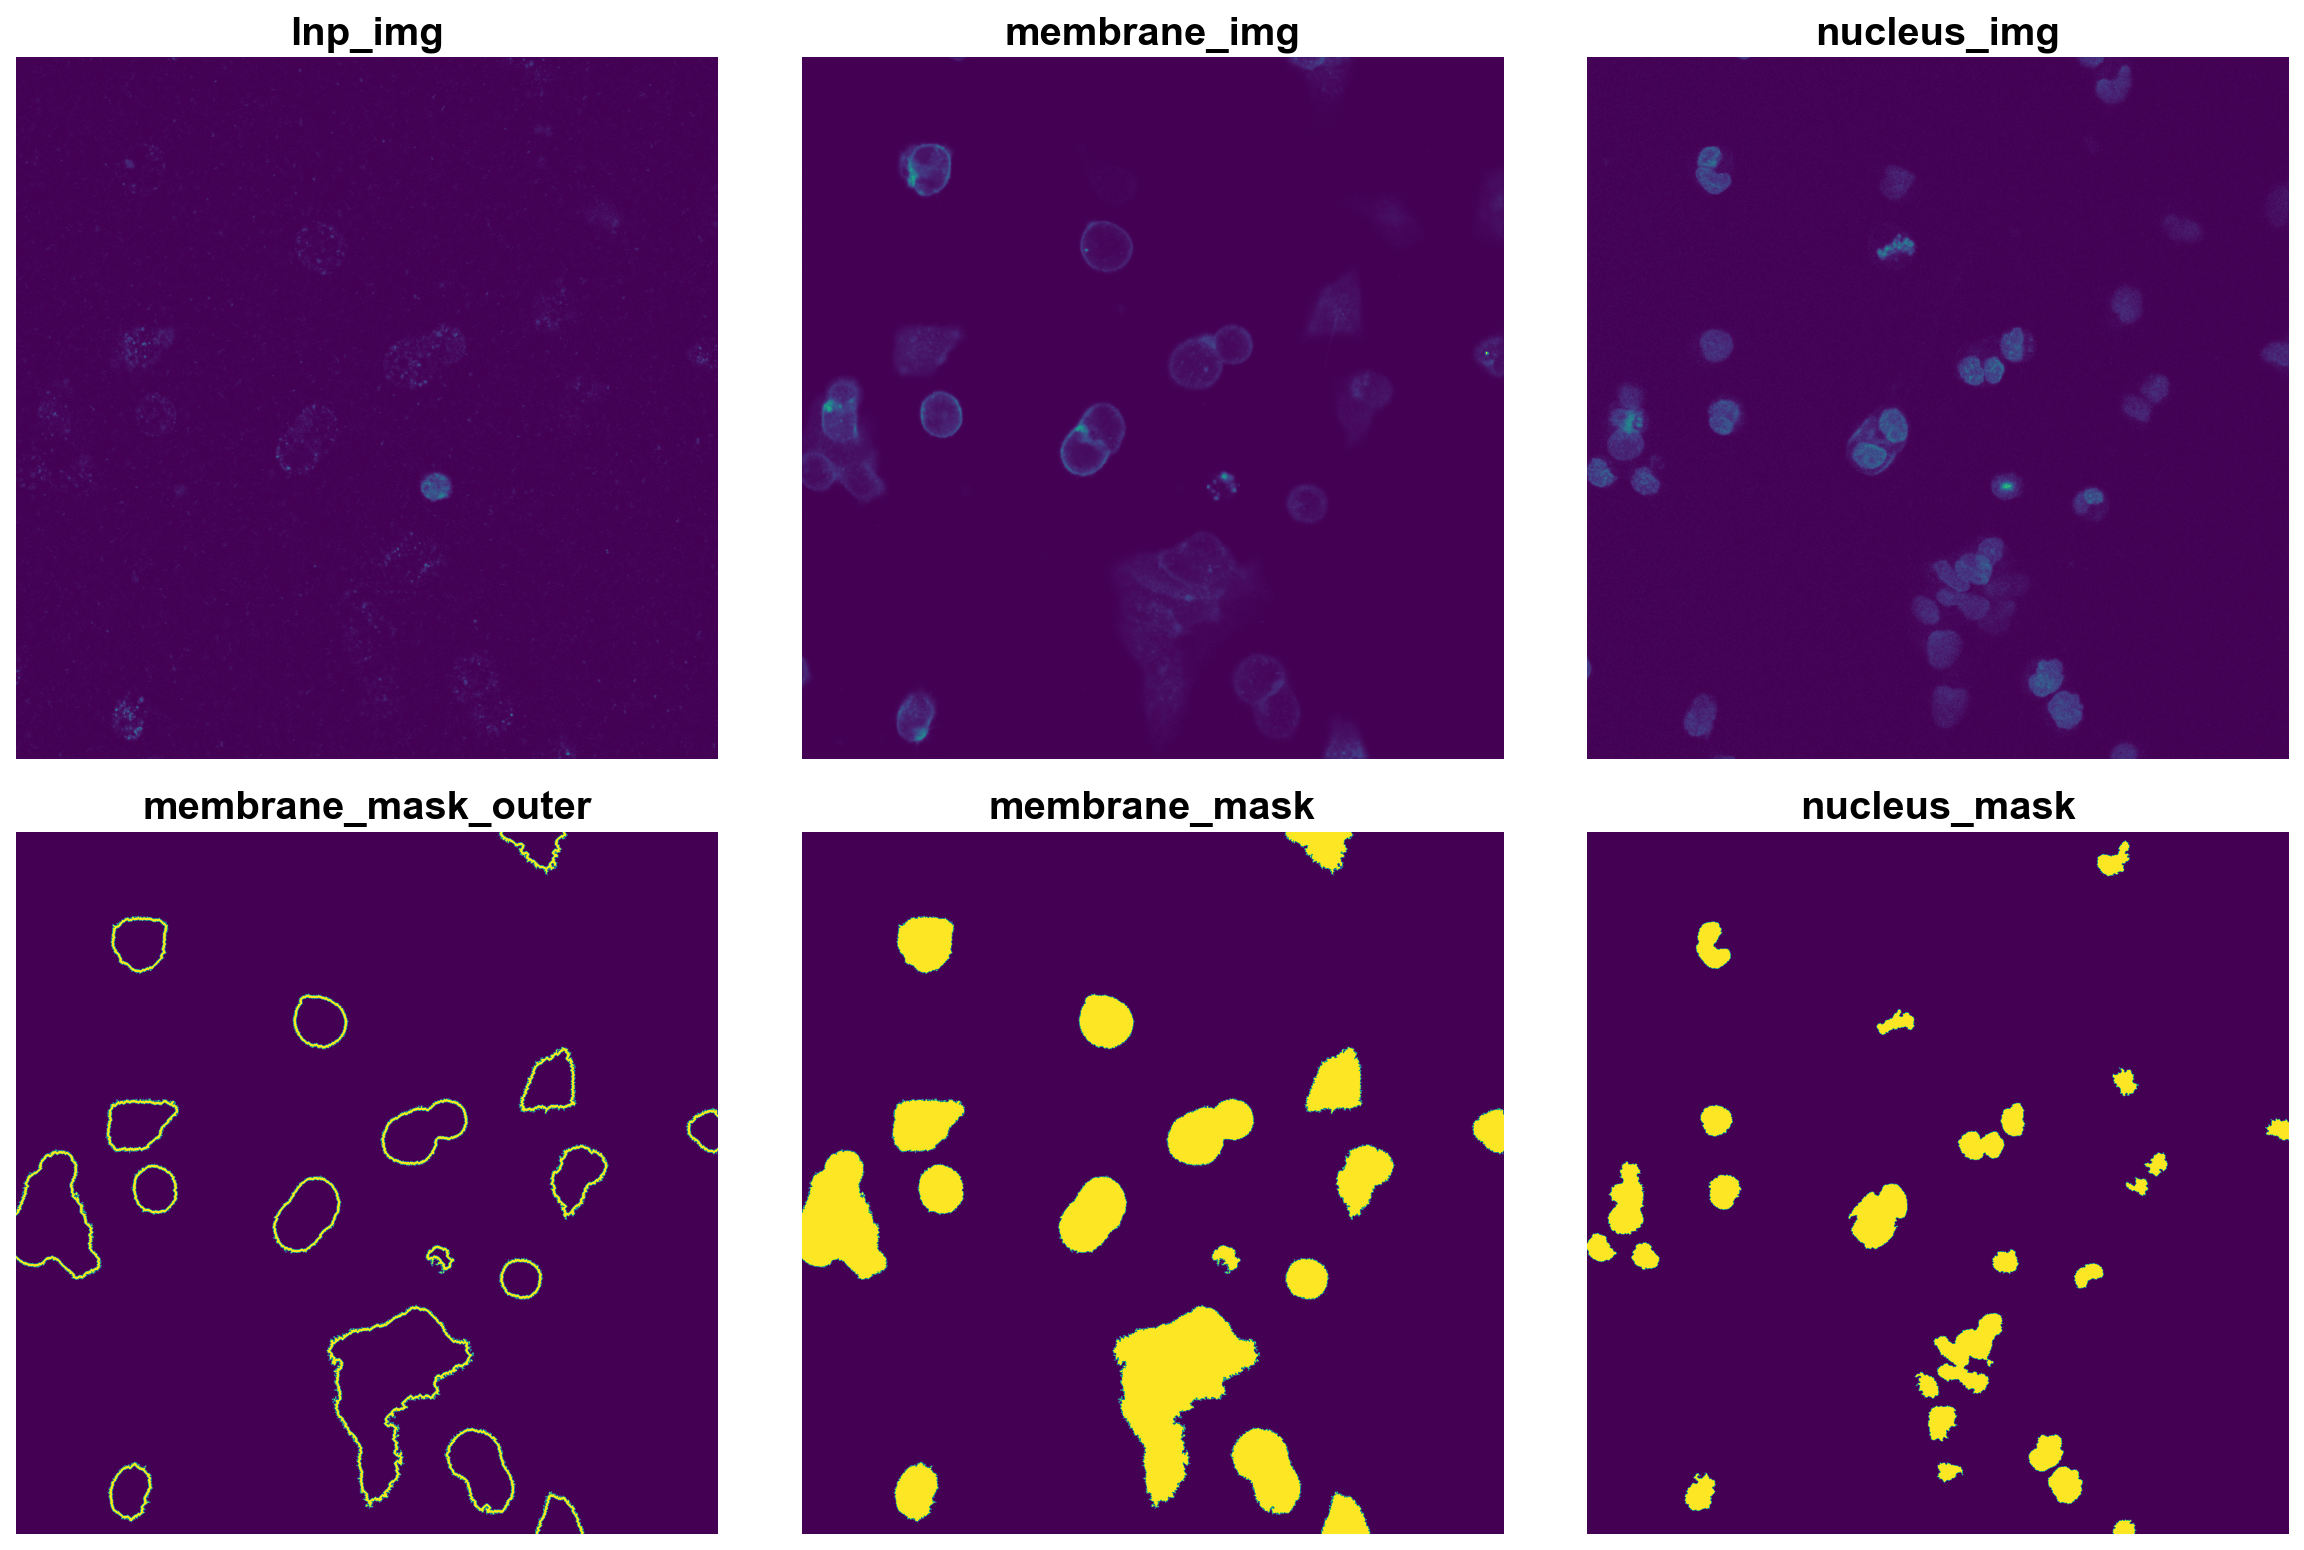

In [7]:
filename_idx = 0
scene_idx = 0
n_erosion = 10

# read the czi image stack
img_filename = os.path.join(IMG_DIR, IMG_FILENAMES[filename_idx])
raw_img = BioImage(img_filename)
img = get_scene_img(raw_img, scene_idx)
lnp_img = img[LNP_CHANNEL_IDX, :, :]
membrane_img = img[MEMBRANE_CHANNEL_IDX, :, :]
nucleus_img = img[NUCLEUS_CHANNEL_IDX, :, :]

membrane_mask = get_membrane_mask(membrane_img)
nucleus_mask = get_nucleus_mask(nucleus_img)
membrane_mask = remove_uncolocalized_objects(membrane_mask, nucleus_mask)
nucleus_mask = remove_uncolocalized_objects(nucleus_mask, membrane_mask)
membrane_mask_inner, membrane_mask_outer = get_inner_outer_membrane_masks(
    membrane_mask, 
    n_erosion=n_erosion,
)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(lnp_img)
axs[0, 1].imshow(membrane_img)
axs[0, 2].imshow(nucleus_img)
axs[1, 0].imshow(membrane_mask_outer)
axs[1, 1].imshow(membrane_mask)
axs[1, 2].imshow(nucleus_mask)

axs[0, 0].set_title('lnp_img')
axs[0, 1].set_title('membrane_img')
axs[0, 2].set_title('nucleus_img')
axs[1, 0].set_title('membrane_mask_outer')
axs[1, 1].set_title('membrane_mask')
axs[1, 2].set_title('nucleus_mask')

for i in range(2):
    for j in range(3):
        axs[i, j].axis('off')
plt.tight_layout()

## Quantifying internalization

In [8]:
def get_object_count(mask):
    return np.unique(measure.label(mask))[-1]

In [9]:
def try_to_numeric(x, errors='raise'):
    try:
        return pd.to_numeric(x, errors=errors)
    except:
        return x

In [10]:
def get_img_in_mask(img, mask):
    masked_img = img.copy()
    masked_img[~mask] = 0
    return masked_img

In [11]:
def save_img(img, img_label):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{img_label}\n{filename}, S{scene_idx}', fontsize=12)
    fig_filepath = os.path.join(f'processed_img/{DATE}', f'{filename}_s{scene_idx}_{img_label}.png')
    fig.savefig(fig_filepath)
    plt.close()

In [16]:
metadata_name_list = [
    'Filename',
    'Scene ID',
    'Number of erosions',
]
property_name_list = [
    'LNP intensity in inner membrane mask',
    'LNP intensity in outer membrane mask',
    
    'Frac LNP intensity in membrane inner mask over LNP intensity in membrane mask',
    'Frac LNP intensity in membrane outer mask over LNP intensity in membrane mask',
]
all_property_name_list = metadata_name_list + property_name_list

In [17]:
sample_property_list = []

for j, filename in enumerate(IMG_FILENAMES):
    filepath = os.path.join(IMG_DIR, filename)
    raw_img = BioImage(filepath)
    for scene_idx in range(len(raw_img.scenes)):
        # get image data
        img = get_scene_img(raw_img, scene_idx)
        lnp_img = img[LNP_CHANNEL_IDX, :, :]
        membrane_img = img[MEMBRANE_CHANNEL_IDX, :, :]
        nucleus_img = img[NUCLEUS_CHANNEL_IDX, :, :]
    
        ## segmentation of membrane and nucleus
        membrane_mask = get_membrane_mask(membrane_img)
        nucleus_mask = get_nucleus_mask(nucleus_img)
        membrane_mask = remove_uncolocalized_objects(membrane_mask, nucleus_mask)
        nucleus_mask = remove_uncolocalized_objects(nucleus_mask, membrane_mask)

        ## masked LNP image
        lnp_in_membrane_img = get_img_in_mask(lnp_img, membrane_mask)
        lnp_in_nucleus_img = get_img_in_mask(lnp_img, nucleus_mask)

        # calculate intensities
        lnp_intensity = lnp_img.sum()
        membrane_intensity = membrane_img.sum()
        nucleus_intensity = nucleus_img.sum()
        lnp_in_membrane_intensity = lnp_in_membrane_img.sum()
        lnp_in_nucleus_intensity = lnp_in_nucleus_img.sum()

        # calculate object counts
        membrane_count = get_object_count(membrane_mask)
        nucleus_count = get_object_count(nucleus_mask)
        
        # erosion related
        for n_erosion in range(1, 21):
            membrane_mask_inner, membrane_mask_outer = get_inner_outer_membrane_masks(
                membrane_mask, 
                n_erosion=n_erosion,
            )
    
            lnp_in_inner_membrane_img = get_img_in_mask(lnp_img, membrane_mask_inner)
            lnp_in_outer_membrane_img = get_img_in_mask(lnp_img, membrane_mask_outer)

            lnp_in_inner_membrane_intensity = lnp_in_inner_membrane_img.sum()
            lnp_in_outer_membrane_intensity = lnp_in_outer_membrane_img.sum()


            sample_property_list.append([
                # meta data
                filename, 
                scene_idx,
                n_erosion,
                
                # intensity in inner/outer membrane masking
                lnp_in_inner_membrane_intensity,
                lnp_in_outer_membrane_intensity,
    
                # fraction of lnp intensity in inner and outer membrane mask vs lnp intensity in membrane mask
                lnp_in_inner_membrane_intensity / lnp_in_membrane_intensity,
                lnp_in_outer_membrane_intensity / lnp_in_membrane_intensity,
            ])


/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_85336/2023478532.py:59: RuntimeWarning: invalid value encountered in scalar divide
  lnp_in_inner_membrane_intensity / lnp_in_membrane_intensity,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_85336/2023478532.py:60: RuntimeWarning: invalid value encountered in scalar divide
  lnp_in_outer_membrane_intensity / lnp_in_membrane_intensity,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_85336/2023478532.py:59: RuntimeWarning: invalid value encountered in scalar divide
  lnp_in_inner_membrane_intensity / lnp_in_membrane_intensity,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_85336/2023478532.py:60: RuntimeWarning: invalid value encountered in scalar divide
  lnp_in_outer_membrane_intensity / lnp_in_membrane_intensity,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_85336/2023478532.py:59: RuntimeWarning: invalid value encountered in scalar divide
  lnp_in_inner_membrane_intensity / ln

In [18]:
properties_df = pd.DataFrame(np.array(sample_property_list))
properties_df.columns = all_property_name_list
properties_df.iloc[:, 1:] = properties_df.iloc[:, 1:].apply(try_to_numeric, **dict(errors='coerce'))
properties_df = properties_df.apply(try_to_numeric)
properties_df

,Filename,Scene ID,Number of erosions,LNP intensity in inner membrane mask,LNP intensity in outer membrane mask,Frac LNP intensity in membrane inner mask over LNP intensity in membrane mask,Frac LNP intensity in membrane outer mask over LNP intensity in membrane mask
0,exp_1_LNP_np.czi,0,1,571350,13927,0.976204,0.023796
1,exp_1_LNP_np.czi,0,2,562254,23023,0.960663,0.039337
2,exp_1_LNP_np.czi,0,3,554435,30842,0.947304,0.052696
3,exp_1_LNP_np.czi,0,4,546186,39091,0.933209,0.066791
4,exp_1_LNP_np.czi,0,5,537905,47372,0.919061,0.080939
...,...,...,...,...,...,...,...
5515,exp_22_LNP_APOE.czi,23,16,1422782,596842,0.704479,0.295521
5516,exp_22_LNP_APOE.czi,23,17,1388619,631005,0.687563,0.312437
5517,exp_22_LNP_APOE.czi,23,18,1355739,663885,0.671283,0.328717
5518,exp_22_LNP_APOE.czi,23,19,1323585,696039,0.655362,0.344638


In [19]:
properties_df_filename = os.path.join(f'processed_data/{DATE}', f"properties_df.csv")
properties_df.to_csv(properties_df_filename)

### Filter for membrane and nucleus count

In [20]:
# filtered_df = properties_df[(properties_df['Nucleus count'] >= 5)]
filtered_df = properties_df.copy()

In [21]:
filtered_df_filename = os.path.join(f'processed_data/{DATE}', f"filtered_df.csv")
filtered_df.to_csv(filtered_df_filename)

### GraphPad Prism Data Export

In [88]:
graph_df = filtered_df.groupby(['Number of erosions', 'Filename']).mean().reset_index()
graph_df

,Number of erosions,Filename,Scene ID,LNP intensity in inner membrane mask,LNP intensity in outer membrane mask,Frac LNP intensity in membrane inner mask over LNP intensity in membrane mask,Frac LNP intensity in membrane outer mask over LNP intensity in membrane mask
0,1,exp_10_LNP_np.czi,5.5,1.018428e+06,12895.083333,0.987367,0.012633
1,1,exp_11_LNP_VTN.czi,5.5,3.764452e+06,50111.833333,0.985804,0.014196
2,1,exp_12_LNP_A2M.czi,5.5,1.102343e+06,14410.250000,0.986396,0.013604
3,1,exp_13_LNP_CR.czi,5.5,1.202679e+06,20495.083333,0.982743,0.017257
4,1,exp_14_cellonly_np.czi,5.5,1.134685e+05,1768.666667,0.984548,0.015452
...,...,...,...,...,...,...,...
435,20,exp_5_LNP_A2M.czi,5.5,8.246098e+05,233892.416667,0.769420,0.230580
436,20,exp_6_cellonly_A2M.czi,5.5,7.991233e+04,26899.416667,0.746983,0.253017
437,20,exp_7_LNP_CR.czi,5.5,7.315821e+05,254134.333333,0.730222,0.269778
438,20,exp_8_cellonly_CR.czi,5.5,9.117608e+04,29914.166667,0.748991,0.251009


In [89]:
graph_property_df = pd.pivot_table(
    graph_df, 
    values='Frac LNP intensity in membrane outer mask over LNP intensity in membrane mask', 
    index=['Number of erosions'],
    columns=['Filename'], 
    aggfunc="mean"
)
graph_property_df

Filename,exp_10_LNP_np.czi,exp_11_LNP_VTN.czi,exp_12_LNP_A2M.czi,exp_13_LNP_CR.czi,exp_14_cellonly_np.czi,exp_15_LNP_np.czi,exp_16_LNP_VTN.czi,exp_17_LNP_A2M.czi,exp_18_LNP_CR.czi,exp_1_LNP_np.czi,...,exp_21_cellonly_APOE.czi,exp_22_LNP_APOE.czi,exp_2_cellonly_np.czi,exp_3_LNP_VTN.czi,exp_4_cellonly_VTN.czi,exp_5_LNP_A2M.czi,exp_6_cellonly_A2M.czi,exp_7_LNP_CR.czi,exp_8_cellonly_CR.czi,exp_9_cellonly_np.czi
Number of erosions,,,,,,,,,,,,,,,,,,,,,
1,0.012633,0.014196,0.013604,0.017257,0.015452,0.015228,0.021272,0.014307,0.016371,0.014654,...,0.051050,0.016197,0.014563,0.028645,0.027495,0.013212,0.016895,0.017938,0.015018,0.011503
2,0.022315,0.026646,0.023879,0.030164,0.026668,0.026580,0.038806,0.024746,0.028723,0.025641,...,0.089904,0.029195,0.025496,0.051161,0.047374,0.022829,0.029148,0.031078,0.026071,0.020009
3,0.031594,0.040007,0.033923,0.042485,0.037458,0.037306,0.056821,0.034677,0.040509,0.036080,...,0.125852,0.042353,0.036125,0.073771,0.065935,0.031906,0.040692,0.043373,0.036446,0.027975
4,0.041006,0.054354,0.044141,0.054709,0.048050,0.047899,0.075502,0.044473,0.052094,0.046715,...,0.159997,0.055921,0.046887,0.096696,0.083825,0.040957,0.051824,0.055307,0.046897,0.035898
5,0.050830,0.069979,0.054845,0.067113,0.058907,0.058683,0.095186,0.054583,0.063868,0.057801,...,0.193247,0.070345,0.058160,0.120568,0.101612,0.050253,0.063111,0.067358,0.057909,0.043709
6,0.061073,0.086483,0.065949,0.079936,0.069858,0.069551,0.115463,0.065072,0.075876,0.069552,...,0.225347,0.085417,0.069768,0.144787,0.119741,0.059860,0.074436,0.079489,0.069184,0.051822
7,0.071738,0.104043,0.077623,0.093164,0.081085,0.080737,0.136521,0.076018,0.088254,0.082005,...,0.256051,0.101318,0.081598,0.169432,0.138068,0.069915,0.085979,0.091916,0.080929,0.060229
8,0.082831,0.122084,0.089627,0.106716,0.092297,0.092147,0.157755,0.087367,0.100719,0.095129,...,0.285863,0.117865,0.094127,0.193721,0.156422,0.080478,0.097874,0.104615,0.092901,0.068815
9,0.094564,0.140543,0.102092,0.120452,0.103858,0.103997,0.179269,0.098948,0.113502,0.108940,...,0.314309,0.135118,0.107094,0.217856,0.174794,0.091551,0.110192,0.117669,0.105319,0.077873


In [90]:
graph_property_df.to_csv(f'processed_data/{DATE}/Frac LNP intensity in membrane outer mask over LNP intensity in membrane mask.csv')

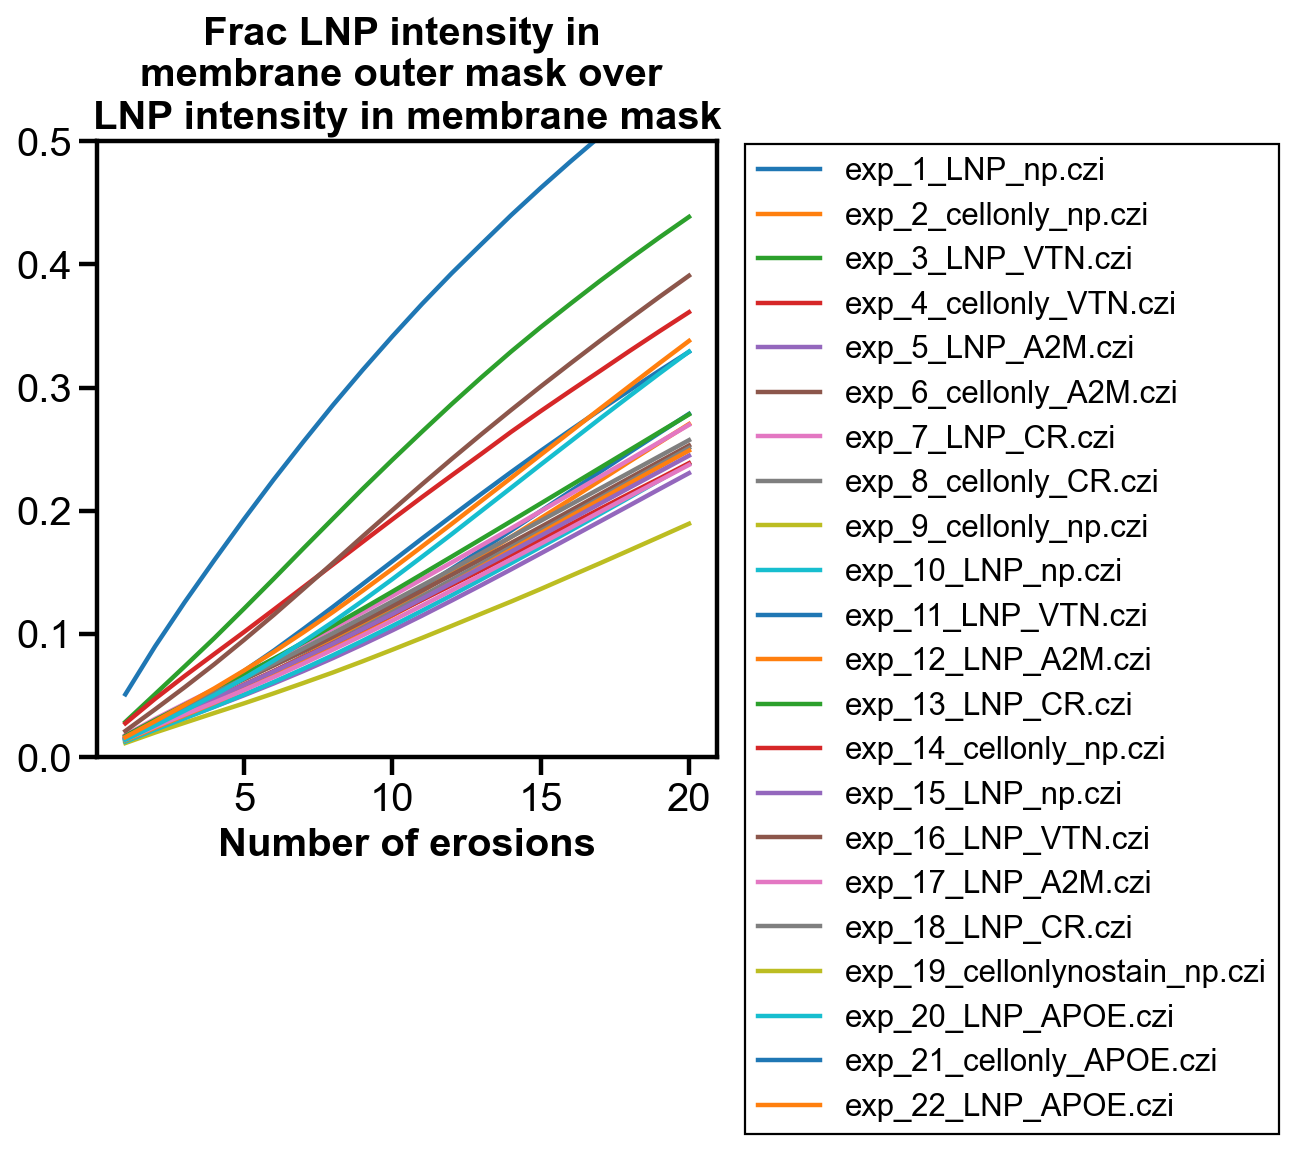

In [84]:
fig, ax = plt.subplots(figsize=(5, 5))
for i, filename in enumerate(IMG_FILENAMES[[0, 9, 14, 2, 10, 15]]):
    ax.plot(np.arange(1, 21), new_df.loc[new_df['Filename'] == filename, 'Frac LNP intensity in membrane outer mask over LNP intensity in membrane mask'], label=filename)
    # ax.plot(np.arange(1, 21), new_df.loc[new_df['Filename'] == filename, 'LNP intensity in outer membrane mask'], label=filename)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))
    ax.set_ylim(0, 0.5)
    ax.set_title('Frac LNP intensity in \nmembrane outer mask over \nLNP intensity in membrane mask')
    ax.set_xlabel('Number of erosions')